# Two-compartment exchange model (2CXM)

In [1]:
# import statements
import os
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from plotting_results_nb import plot_bland_altman, bland_altman_statistics
import json
from pathlib import Path

## Test data

Data summary: simulated two-compartment exchange model data

Source: Concentration-time data (n = 24) generated by M. Thrippleton using Matlab code at https://github.com/mjt320/DCE-functions

Detailed info:
- Temporal resolution: 0.5 s
- Acquisition time: 300 s
- AIF: Parker function, starting at t=10s
- Noise: SD = 0.001 mM
- Arterial delay: none or 5s
Since it is challenging to fit all parameters across a wide area of parameter space, data is generated with high SNR.
 
Reference values: Reference values are the parameters used to generate the data. All combinations of $v_p$ (0.02, 0.1), $v_e$ (0.1, 0.2), $f_p$ (5 to 40 100ml/ml/min) and PS (0.05 to 0.15 per min) are included.
A delayed version of the test data was created by shifting the time curves with 5s. This data is labeled as 'delayed' and only used with the models that allow the fitting of a delay.

Citation: Code used in Manning et al., Magnetic Resonance in Medicine, 2021 https://doi.org/10.1002/mrm.28833 and Matlab code: https://github.com/mjt320/DCE-functions

Tolerances
- $v_p$: a_tol=0.025, r_tol=0, start=0.01, bounds=(0,1)
- $v_e$: a_tol=0.05, r_tol=0, start=0.2, bounds=(0,1)
- $f_p$: a_tol=5, r_tol=0.1, start=20, bounds=(0,200), units ml/100ml/min
- PS: a_tol=0.005, r_tol=0.1, start=0.6, bounds=(0,5), units [/min]
- delay: a_tol=0.5, r_tol=0, start=0, bounds=(-10,10), units s




### Visualize test data
To get an impression of the test data, the concentration time curves of the test data are plotted below.

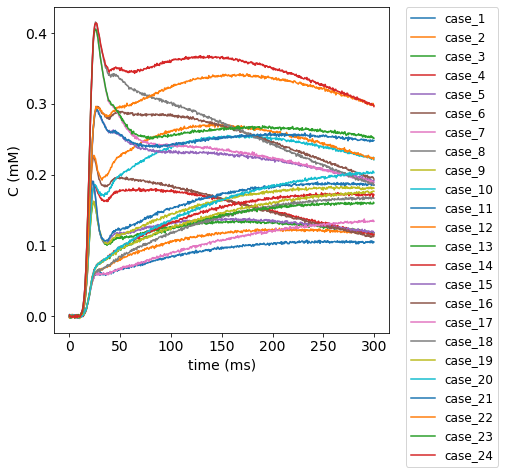

In [2]:
#plot test data
filename = ('../test/DCEmodels/data/2cxm_sd_0.001_delay_0.csv')
# read from CSV to pandas
df1 = pd.read_csv(filename)

no_voxels = len(df1.label)

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(6,6))
for currentvoxel in range(no_voxels):
    labelname = 'case_' + str(currentvoxel+1)
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C_t'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax.plot(t, c, label=labelname)
    
ax.set_ylabel('C (mM)', fontsize=14)
ax.set_xlabel('time (ms)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,fontsize=12);   
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

    

## Import data

In [3]:
# Load the meta data
meta = json.load(open("../test/results-meta.json"))

In [4]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if (entry['category'] == 'DCEmodels') & (entry['method'] == '2CXM') :
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [5]:
author_list = df.author.unique()
no_authors = len(author_list)

# split delayed and non-delayed data
df['delay'] = df['label'].str.contains('_delayed')

# calculate error between measured and reference values
df['error_ps'] = df['ps_meas'] - df['ps_ref']
df['error_vp'] = df['vp_meas'] - df['vp_ref']
df['error_ve'] = df['ve_meas'] - df['ve_ref']
df['error_fp'] = df['fp_meas'] - df['fp_ref']

# tolerances
tolerances = { 'ps': {'atol' : 0.005, 'rtol': 0.1 }, 'vp': {'atol':0.025, 'rtol':0}, 've': {'atol':0.05, 'rtol':0}, 'fp': {'atol':5, 'rtol':0.1}}

## Results

### Non-delayed data

Some models allow the fit of a delay. For the tests with non-delayed data, the delay was fixed to 0.
If the tolerances are not shown, it means that they are outside the limits of the y-axis.

In [6]:
df.head(n=23)[['label','ps_ref','vp_ref', 've_ref','fp_ref']]

,label,ps_ref,vp_ref,ve_ref,fp_ref
0,case_1,0.05,0.02,0.1,5
1,case_2,0.15,0.02,0.1,5
2,case_3,0.05,0.02,0.1,25
3,case_4,0.15,0.02,0.1,25
4,case_5,0.05,0.02,0.1,40
5,case_6,0.15,0.02,0.1,40
6,case_7,0.05,0.02,0.2,5
7,case_8,0.15,0.02,0.2,5
8,case_9,0.05,0.02,0.2,25
9,case_10,0.15,0.02,0.2,25


In [7]:
# set-up styling for seaborn plots
sns.set(font_scale=1.5)
#sns.set_style("whitegrid")
sns.set_style("ticks")


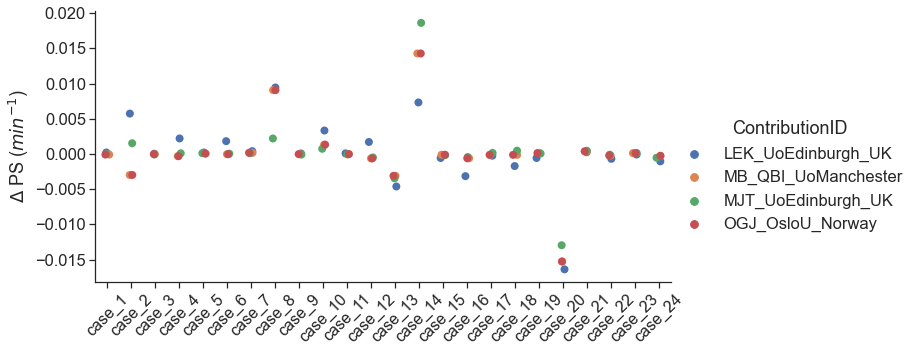

In [8]:
# instead of a regular bland-altman plot we opted for a catplot + swarm for these results. In this way we can appreciate the results of the different contributions per test case better.
# the downside is that the values of the test cases are not obvious. This might be something to improve upon at a later stage

g = sns.catplot(x='label', y="error_ps",
              data=df[~df['delay']], hue="author", s=8, aspect=2)
g.set(xlabel=None)
g.set_ylabels("$\Delta$ PS ($min^{-1}$)", clear_inner=False);
g.set_xticklabels(rotation=45, fontsize=16)
g._legend.set_title('ContributionID')
plt.show()

Bias results estimated PS values combined for all voxels

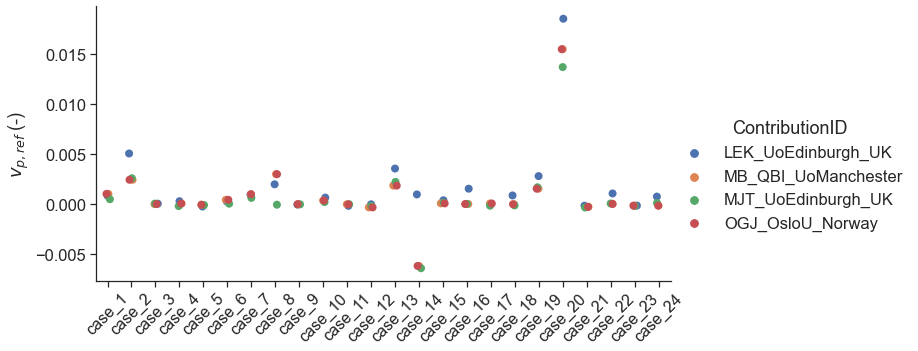

In [9]:
# instead of a regular bland-altman plot we opted for a catplot + swarm for these results. In this way we can appreciate the results of the different contributions per test case better.
# the downside is that the values of the test cases are not obvious. This might be something to improve upon at a later stage

g = sns.catplot(x='label', y="error_vp",
              data=df[~df['delay']], hue="author", s=8, aspect=2)
g.set(xlabel=None)
g.set_ylabels("$v_{p,ref}$ (-)", clear_inner=False);
g.set_xticklabels(rotation=45, fontsize=16)
g._legend.set_title('ContributionID')
plt.show()

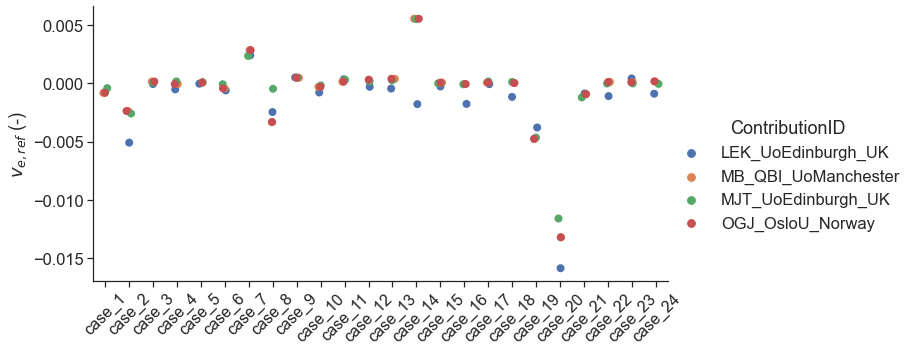

In [10]:
# instead of a regular bland-altman plot we opted for a catplot + swarm for these results. In this way we can appreciate the results of the different contributions per test case better.
# the downside is that the values of the test cases are not obvious. This might be something to improve upon at a later stage

g = sns.catplot(x='label', y="error_ve",
              data=df[~df['delay']], hue="author", s=8, aspect=2)
g.set(xlabel=None)
g.set_ylabels("$v_{e,ref}$ (-)", clear_inner=False);
g.set_xticklabels(rotation=45, fontsize=16)
g._legend.set_title('ContributionID')
plt.show()

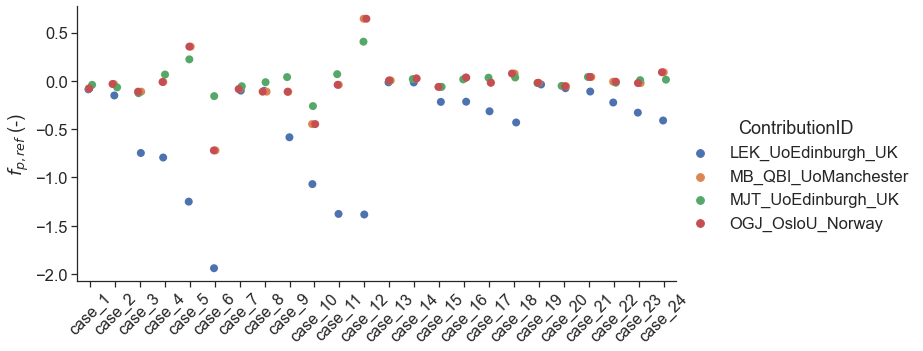

In [11]:
# instead of a regular bland-altman plot we opted for a catplot + swarm for these results. In this way we can appreciate the results of the different contributions per test case better.
# the downside is that the values of the test cases are not obvious. This might be something to improve upon at a later stage

g = sns.catplot(x='label', y="error_fp",
              data=df[~df['delay']], hue="author", s=8, aspect=2)
g.set(xlabel=None)
g.set_ylabels("$f_{p,ref}$ (-)", clear_inner=False);
g.set_xticklabels(rotation=45, fontsize=16)
g._legend.set_title('ContributionID')
plt.show()

In [12]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_ps',grouptag='author')
print(resultsBA)

                         bias     stdev  LoA lower  LoA upper
author                                                       
LEK_UoEdinburgh_UK   0.000150  0.004673  -0.009010   0.009309
MB_QBI_UoManchester  0.000061  0.004847  -0.009440   0.009561
MJT_UoEdinburgh_UK   0.000259  0.004817  -0.009183   0.009701
OGJ_OsloU_Norway     0.000061  0.004847  -0.009440   0.009561


Bias results estimated $v_p$ values combined for all voxels

In [13]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_vp',grouptag='author')
print(resultsBA)

                         bias     stdev  LoA lower  LoA upper
author                                                       
LEK_UoEdinburgh_UK   0.001673  0.003827  -0.005828   0.009173
MB_QBI_UoManchester  0.000856  0.003520  -0.006044   0.007756
MJT_UoEdinburgh_UK   0.000606  0.003206  -0.005678   0.006889
OGJ_OsloU_Norway     0.000856  0.003520  -0.006044   0.007756


Bias results estimated $v_e$ values combined for all voxels

In [14]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_ve',grouptag='author')
print(resultsBA)

                         bias     stdev  LoA lower  LoA upper
author                                                       
LEK_UoEdinburgh_UK  -0.001461  0.003401  -0.008127   0.005204
MB_QBI_UoManchester -0.000666  0.003261  -0.007058   0.005725
MJT_UoEdinburgh_UK  -0.000492  0.002916  -0.006207   0.005223
OGJ_OsloU_Norway    -0.000666  0.003261  -0.007058   0.005725


Bias results estimated $f_p$ values combined for all voxels

In [15]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_fp',grouptag='author')
print(resultsBA)

                         bias     stdev  LoA lower  LoA upper
author                                                       
LEK_UoEdinburgh_UK  -0.499689  0.535799  -1.549855   0.550476
MB_QBI_UoManchester -0.028328  0.239519  -0.497785   0.441130
MJT_UoEdinburgh_UK   0.003312  0.124339  -0.240393   0.247016
OGJ_OsloU_Norway    -0.028328  0.239519  -0.497785   0.441130


### Delayed results

Some contributions allowed the fitting of a delay. For those, additional tests with a delay were performed.

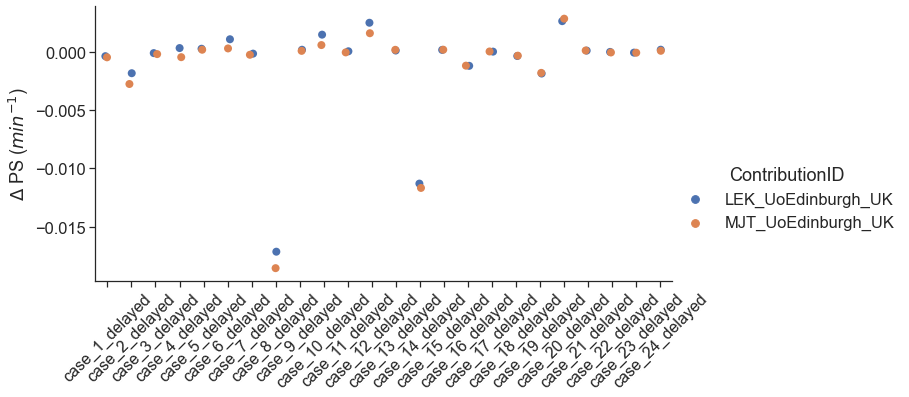

In [16]:
# instead of a regular bland-altman plot we opted for a catplot + swarm for these results. In this way we can appreciate the results of the different contributions per test case better.
# the downside is that the values of the test cases are not obvious. This might be something to improve upon at a later stage

g = sns.catplot(x='label', y="error_ps",
              data=df[df['delay']], hue="author", s=8, aspect=2)
g.set(xlabel=None)
g.set_ylabels("$\Delta$ PS ($min^{-1}$)", clear_inner=False);
g.set_xticklabels(rotation=45, fontsize=16)
g._legend.set_title('ContributionID')
plt.show()

Bias results estimated PS values combined for all voxels

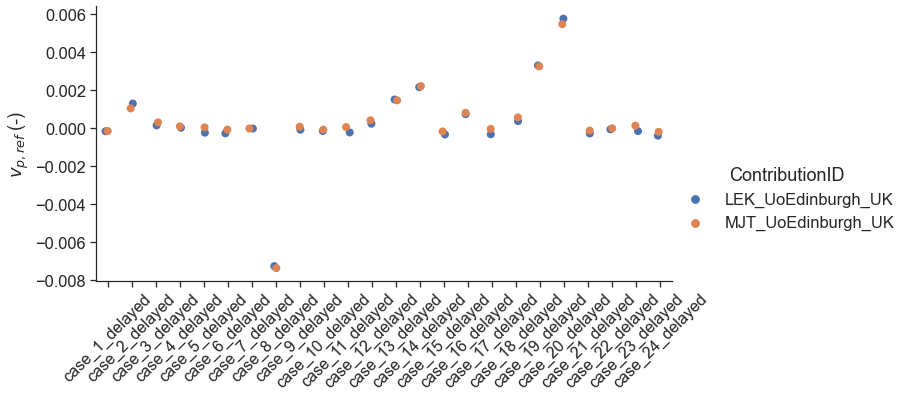

In [17]:
# instead of a regular bland-altman plot we opted for a catplot + swarm for these results. In this way we can appreciate the results of the different contributions per test case better.
# the downside is that the values of the test cases are not obvious. This might be something to improve upon at a later stage

g = sns.catplot(x='label', y="error_vp",
              data=df[df['delay']], hue="author", s=8, aspect=2)
g.set(xlabel=None)
g.set_ylabels("$v_{p,ref}$ (-)", clear_inner=False);
g.set_xticklabels(rotation=45, fontsize=16)
g._legend.set_title('ContributionID')
plt.show()

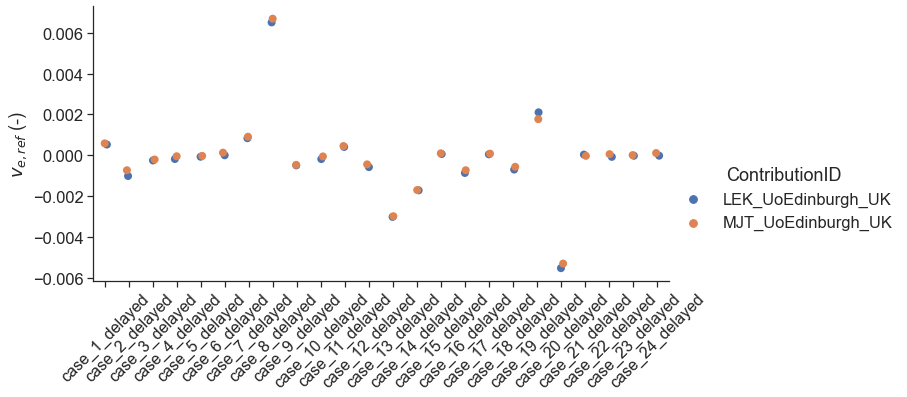

In [18]:
# instead of a regular bland-altman plot we opted for a catplot + swarm for these results. In this way we can appreciate the results of the different contributions per test case better.
# the downside is that the values of the test cases are not obvious. This might be something to improve upon at a later stage

g = sns.catplot(x='label', y="error_ve",
              data=df[df['delay']], hue="author", s=8, aspect=2)
g.set(xlabel=None)
g.set_ylabels("$v_{e,ref}$ (-)", clear_inner=False);
g.set_xticklabels(rotation=45, fontsize=16)
g._legend.set_title('ContributionID')
plt.show()

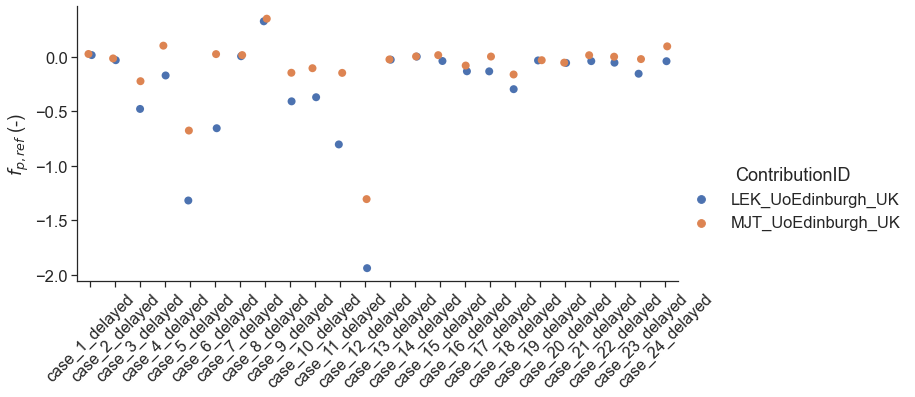

In [19]:
# instead of a regular bland-altman plot we opted for a catplot + swarm for these results. In this way we can appreciate the results of the different contributions per test case better.
# the downside is that the values of the test cases are not obvious. This might be something to improve upon at a later stage

g = sns.catplot(x='label', y="error_fp",
              data=df[df['delay']], hue="author", s=8, aspect=2)
g.set(xlabel=None)
g.set_ylabels("$f_{p,ref}$ (-)", clear_inner=False);
g.set_xticklabels(rotation=45, fontsize=16)
g._legend.set_title('ContributionID')
plt.show()

## Notes
Additional notes/remarks

### References